In [1]:
import pandas as pd
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
import seaborn as sns

/Users/hushuyi/opt/anaconda3/envs/hw3154/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-10 09:51:11.509890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


# Load the dataset

<Axes: xlabel='label', ylabel='count'>

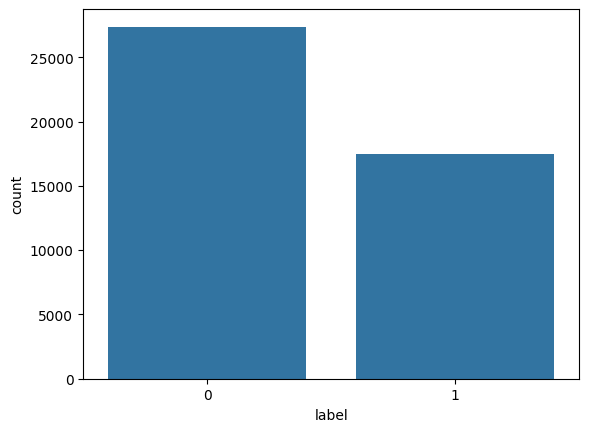

In [2]:

train = pd.read_csv('llm-detect-ai-generated-text/train_v2_drcat_02.csv', sep=',')
# Visualization
sns.countplot(data=train,x="label")


# Tokenization and dataset split

In [3]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokens = tokenizer(train["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
y = train['label'].values
X = tokens["input_ids"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10)
X_train = tf.convert_to_tensor(X_train.numpy(), dtype=tf.int64)
X_val = tf.convert_to_tensor(X_val.numpy(), dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test.numpy(), dtype=tf.int64)



Epoch 1/7
253/253 [==============================] - 94s 359ms/step - loss: 0.1427 - accuracy: 0.9398
Epoch 2/7
253/253 [==============================] - 100s 394ms/step - loss: 0.0322 - accuracy: 0.9913
Epoch 3/7
253/253 [==============================] - 85s 337ms/step - loss: 0.0135 - accuracy: 0.9967
Epoch 4/7
253/253 [==============================] - 87s 344ms/step - loss: 0.0180 - accuracy: 0.9954
Epoch 5/7
253/253 [==============================] - 86s 338ms/step - loss: 0.0102 - accuracy: 0.9974
Epoch 6/7
253/253 [==============================] - 89s 353ms/step - loss: 0.0078 - accuracy: 0.9981
Epoch 7/7
253/253 [==============================] - 88s 348ms/step - loss: 0.0063 - accuracy: 0.9987


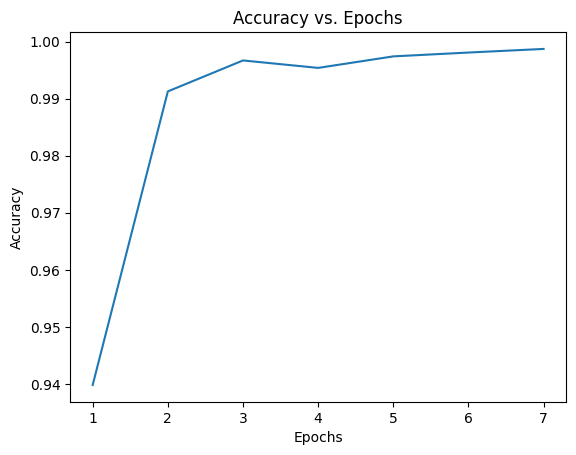

In [4]:
# Define the LSTM model
embedding_vector_features=45
model = Sequential()
model.add(Embedding(31000,embedding_vector_features))
model.add(Bidirectional(LSTM(units=64 , return_sequences=False)))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=100 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Plot the training accuracy curve (threshold = 0.5)
class AccuracyHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.accuracy.append(logs.get('accuracy'))

accuracy_history = AccuracyHistory()

epochs=7

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=100, callbacks=[accuracy_history])
plt.plot(range(1, epochs + 1), accuracy_history.accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.show()


263/263 [==============================] - 15s 52ms/step


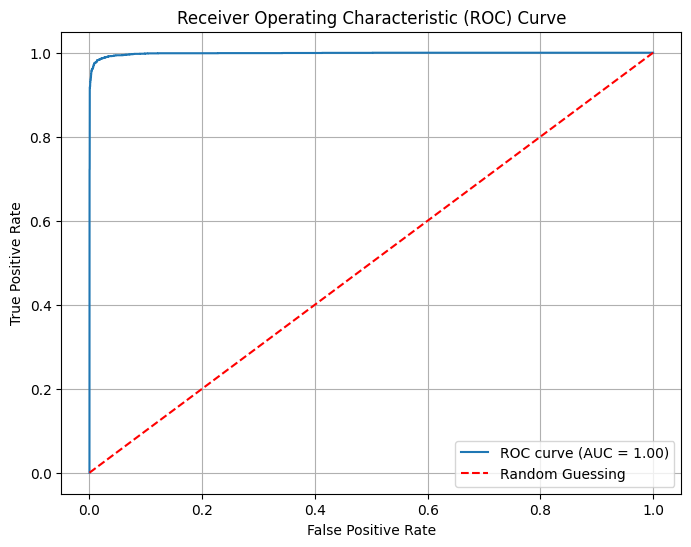

In [5]:
#ROC curve
predictions = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, predictions)
roc_auc = roc_auc_score(y_val, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
model.summary()
print("LSTM model AUC:", roc_auc)
predictions = model.predict(X_val)
new_prediction = [1 if x > 0.5 else 0 for x in predictions]
correct_predictions = (new_prediction == y_val)
accuracy = sum(correct_predictions) / len(y_val)
print("LSTM model validation accuracy: ", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 45)          1395000   
                                                                 
 bidirectional (Bidirection  (None, 128)               56320     
 al)                                                             
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

# Test accuracy and AUC

Epoch 1/7
337/337 [==============================] - 133s 377ms/step - loss: 0.1804 - accuracy: 0.9329
Epoch 2/7
337/337 [==============================] - 117s 346ms/step - loss: 0.0595 - accuracy: 0.9810
Epoch 3/7
337/337 [==============================] - 117s 349ms/step - loss: 0.0197 - accuracy: 0.9944
Epoch 4/7
337/337 [==============================] - 119s 353ms/step - loss: 0.0318 - accuracy: 0.9906
Epoch 5/7
337/337 [==============================] - 114s 337ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 6/7
337/337 [==============================] - 112s 331ms/step - loss: 0.0091 - accuracy: 0.9976
Epoch 7/7
337/337 [==============================] - 124s 367ms/step - loss: 0.0054 - accuracy: 0.9986


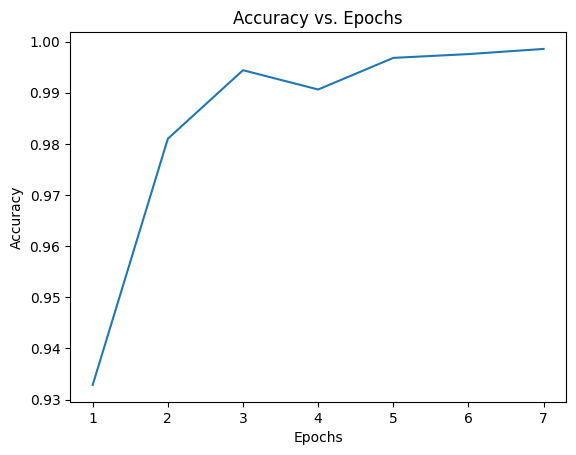

351/351 [==============================] - 20s 54ms/step


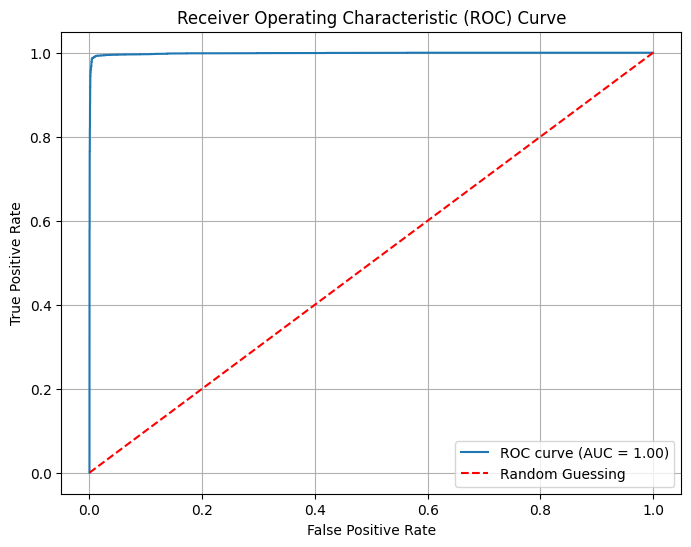

LSTM model AUC: 0.9985874516296349
351/351 [==============================] - 22s 63ms/step
LSTM model test accuracy:  0.9904609075510385


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
X_train = tf.convert_to_tensor(X_train.numpy(), dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test.numpy(), dtype=tf.int64)
embedding_vector_features=45
model = Sequential()
model.add(Embedding(31000,embedding_vector_features))
model.add(Bidirectional(LSTM(units=64 , return_sequences=False)))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=100 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Plot the training accuracy curve (threshold = 0.5)
class AccuracyHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.accuracy.append(logs.get('accuracy'))

accuracy_history = AccuracyHistory()

epochs=7

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=100, callbacks=[accuracy_history])
plt.plot(range(1, epochs + 1), accuracy_history.accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.show()
#ROC curve
predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
print("LSTM model AUC:", roc_auc)
predictions = model.predict(X_test)
new_prediction = [1 if x > 0.5 else 0 for x in predictions]
correct_predictions = (new_prediction == y_test)
accuracy = sum(correct_predictions) / len(y_test)
print("LSTM model test accuracy: ", accuracy)
